https://github.com/MateoFdezEspina/BarcelonaAirbnb

git add notebooks/00results.ipynb notebooks/00EDA.ipynb notebooks/01linear.ipynb notebooks/02gwr.ipynb notebooks/08_mesf.ipynb notebooks/05_0_svr_linear.ipynb notebooks/06_1_gwsvr.ipynb  

git commit -m "Describe your update"
git push

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [4]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PowerTransformer
from urbana.features.selection import KBestSelector

from sklearn.model_selection import KFold, GridSearchCV

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.svm import SVR

In [5]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = False
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

# Number of selected variables in these categories
K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 2
K_RENT = 1
K_POI = 10

# Warnings
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter check
ALLOWED_YEARS = [2017, 2018, 2023]

if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

# Create folders to store the data
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_SVR = DIR_MONTH / "05_svr_linear"

if SAVE_FIGS:
    folder_list = [
        DIR_SVR,
        DIR_SVR / "coefficients",
    ]
    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

PATH_TO_FILE = DIR_MONTH / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "01linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

# Data Import

In [6]:
sect = pd.read_csv(DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH))
sect.set_index("Tag", inplace=True)
sect.drop(
    [
        "N_district",
        "N_neighbourhood",
        "N_section",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
        "Percentage_Age_25_39",
    ],
    axis=1,
    inplace=True,
)

X = sect.drop(VARIABLE_TO_PREDICT, axis=1)
y = sect[VARIABLE_TO_PREDICT]

geo_info = gpd.read_file(DIR_DATA / "interim/sections_geo.json")
geo_info.set_index("Tag", inplace=True)
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

# 1st model: All features

Support Vector Regression (SVR)

Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. Firstly, because we are dealing with regression instead of classification, the goal is to fit the error within a certain threshold.

### Objective Function

The SVR has a linear function defined as:

$$
f(x) = \mathbf{w}^T \mathbf{x} + b
$$

where $ \mathbf{w} $ represents the coefficient vector, $ \mathbf{x} $ is the feature vector, and $ b $ is the bias.

### Loss Function

The objective of SVR is to minimize the coefficient vector $ \mathbf{w} $, while keeping the errors within a certain margin $ \epsilon $. The model tries to ensure that the errors for each data point $ (x_i, y_i) $ are less than $ \epsilon $, but at the same time, it allows some flexibility by introducing slack variables $ \xi_i $ and $ \xi_i^* $. The optimization problem can be written as:

$$
\min_{\mathbf{w}, b, \xi, \xi^*} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*)
$$

subject to:

$$
\begin{align*}
y_i - \mathbf{w}^T \mathbf{x}_i - b &\leq \epsilon + \xi_i \\
\mathbf{w}^T \mathbf{x}_i + b - y_i &\leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* &\geq 0
\end{align*}
$$

### Parameters:

- $ \mathbf{w} $, $ b $: Parameters of the regression model.
- $ \xi_i $, $ \xi_i^* $: Slack variables to allow some errors to be greater than $ \epsilon $.
- $ C $: Regularization parameter, which controls the trade-off between achieving a low error on the training data and minimizing the model complexity.
- $ \epsilon $: Specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance $ \epsilon $ from the actual values.

The parameter $ C $ serves as a regularization parameter in the SVR optimization formulation. A smaller $ C $ encourages a larger margin (hence more regularization), and a larger $ C $ encourages a smaller margin (hence less regularization, fitting tighter to the data). The $ \epsilon $ parameter defines the width of the tube which measures the deviation of the predictions from the actual data points allowed in the model.


### Hyper-parameter Optimization ($\epsilon$ and $C$)
(Without kernel for the moment)

For the moment, all variables are selected. The purpose of this section is to have a first approach of the SVR model using different combinations of its hyper-parameters ($\epsilon$ and $C$) with all the variables. 

Preprocessing Pipeline: 
- Imputation: KNNImputer fills in missing values to ensure the dataset is complete before further processing
- Power Transformation: it normalizes the distribution, reducing skewness and stabilizing variance
- Scaling: StandardScaler standardizes the data, ensuring it has zero mean and unit variance, contributing to consistent model training

In [7]:
# imputer = KNNImputer()
# scaler = StandardScaler()

# pipeline = Pipeline(
#     [
#         ("imputer", imputer),
#         # ("power_transformer", power_transformer),
#         ("scaler", scaler),
#         ("svr", SVR(kernel="linear")),
#     ]
# )

# # HPO grid definition
# Cl = 0
# Ch = 10
# param_grid = {
#     "svr__C": [2**l for l in range(Cl, Ch + 1)],  # C in a range from Cl to Ch
#     "svr__epsilon": [10**i for i in range(-5, 2)],  # epsilon from 0.1 to 1
# }

# print(param_grid)

# # inner evaluation: 10-fold crossvalidation
# folds = 3
# kf = KFold(n_splits=folds, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     pipeline, param_grid, cv=kf, n_jobs=-1, scoring="neg_mean_squared_error"
# )
# grid_search.fit(X, y)

### Results plot

In [8]:
# cv_results = grid_search.cv_results_

# # Data for the heat map
# param_C = [params["svr__C"] for params in cv_results["params"]]
# param_epsilon = [params["svr__epsilon"] for params in cv_results["params"]]
# mean_test_mse = -1 * cv_results["mean_test_score"]

# df_results = pd.DataFrame(
#     {"C": param_C, "epsilon": param_epsilon, "MSE": mean_test_mse}
# )

# result_matrix = df_results.pivot(index="C", columns="epsilon", values="MSE")

# plt.figure(figsize=(8, 5))
# sns.heatmap(
#     result_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "MSE"}
# )
# plt.title("HeatMap of MSE for Different Combinations of C and epsilon")
# plt.xlabel("Epsilon")
# plt.ylabel("C")
# plt.show()

In [9]:
# best_params = grid_search.best_params_
# best_model_1 = grid_search.best_estimator_

# print("Best parameters:", best_params)

In [10]:
# svr_model_1 = best_model_1.named_steps["svr"]

# intercept = svr_model_1.intercept_
# support_vectors = svr_model_1.support_vectors_
# dual_coefficients = svr_model_1.dual_coef_
# support_indices = svr_model_1.support_

# print("Intercept:", intercept)  # bias term, representing the offset from the origin
# # print("Support Vectors:", support_vectors)  # indices of the support vectors in the training set
# # print("Dual Coefficients:", dual_coefficients)     #support vectors used by the SVR model
# # print("Support Indices:", support_indices)  # dual coefficients of the support vectors

# # print(search_kbest.cv_results_)

In [11]:
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("scaler", StandardScaler())])

pipe_svr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", SVR(C=1024, epsilon=1, kernel='linear'))]
)

Understanding the output of the SVR model: 

- In this case, the input is a 1068 x 84 matrix. 

The result of an SVR model is a function of the following shape: $f(x)=w\cdot x + b$

- The intercept is $b$ in the equation, being the point at which the hyperplane intersects the y-axis in the feature space. 

- Support vectors are the data points from the boundary used to define the shape and position of the hyperplane. These have a very similar shape to the original matrix. 

### Model evaluation

In [12]:
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

y_truth = pd.Series(y, name="True Data")  # real y values

model_svr = pipe_svr.fit(X, y)

y_pred = model_svr.predict(X)  # predicted values over the testing set

y_pred = pd.Series(
    y_pred, index=geo_info.index, name="Linear SVR"
)  # relating the pred values with the geographical tags

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
n, p = len(y), X.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
evs = explained_variance_score(y, y_pred)
aic = len(y) * np.log(mse) + 2 * p

residuals = y - y_pred

svr_metrics = {
    "MSE": [mse],
    "RMSE": [rmse],
    "R^2": [r2],
    "Adj R^2": [adjusted_r2],
    "EVs": [evs],
    "AIC": [aic],
}
df_svr_metrics = pd.DataFrame(svr_metrics, index=["Linear SVR"])

df_metrics = pd.read_csv("metrics.csv", index_col=0)
df_metrics = pd.concat([df_metrics, df_svr_metrics])
df_metrics.to_csv("metrics.csv", index=True)
df_metrics

,MSE,RMSE,R^2,Adj R^2,EVs,AIC
Linear Regression,119.908203,10.950260,0.818644,0.803146,0.818644,5280.223871
GWR,128.109551,11.318549,0.806239,0.789682,0.808532,1529.338979
MESF-Queen,115.669618,10.754981,0.825054,0.808153,0.825054,5261.788195
MESF-KNN,116.309755,10.784700,0.824086,0.807091,0.824086,5267.682404
MESF-Gabriel,114.353896,10.693638,0.827044,0.810335,0.827044,5249.570252
SVR,0.914437,0.956262,0.998617,0.998499,0.998676,72.470973
GWSVR,158.500932,12.589715,0.760273,0.739788,0.762626,5578.232186
SVR,0.914437,0.956262,0.998617,0.998499,0.998676,72.470973
SVR,0.914437,0.956262,0.998617,0.998499,0.998676,72.470973


#### Spatial Autocorrelation handling

##### Moran's I on residuals 

In [13]:
from libpysal.weights import Queen
from esda.moran import Moran


def calculate_morans_i(residuals, geo_info):
    w = Queen.from_dataframe(geo_info)
    w.transform = "R"
    moran = Moran(residuals, w)
    return moran.I, moran.p_sim


moran = calculate_morans_i(residuals, geo_info)
print(f"Moran's I: {moran[0]}, p-value: {moran[1]}")

Moran's I: 0.09860385442669521, p-value: 0.001


##### Cross validation with training and test sets for different sections

In [14]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = cross_val_score(pipe_svr, X, y, cv=kf, scoring="neg_mean_squared_error")

mean_mse = -np.mean(mse_scores)

In [15]:
autocorr_metrics = {"Moran's I": [moran[0]], "Mean MSE": [mean_mse]}
df_autocorr_svr_metrics = pd.DataFrame(autocorr_metrics, index=["Linear SVR"])

df_autocorr_metrics = pd.read_csv("metrics_autocorr.csv", index_col=0)
df_autocorr_metrics = pd.concat([df_autocorr_metrics, df_autocorr_svr_metrics])
df_autocorr_metrics.to_csv("metrics_autocorr.csv", index=True)
df_autocorr_metrics

,Moran's I,Mean MSE
Linear Regression,0.133607,181.599291
GWR,0.091858,192.927322
MESF-Queen,0.110892,275.651324
MESF-KNN,0.093927,215.337178
MESF-Gabriel,0.050416,253.331825
SVR,0.098604,280.698096
GWSVR,0.284684,NaN
SVR,0.098604,280.698096
SVR,0.098604,280.698096


In [16]:
df_predictions_svr = pd.DataFrame({"SVR": np.array(y_pred)})
df_predictions = pd.read_csv("predictions.csv", index_col=0)
df_predictions = pd.concat([df_predictions, df_predictions_svr], axis=1)
df_predictions.to_csv("predictions.csv")
df_predictions

,y,Linear Regression,GWR,MESF-Q,MESF-K,MESF-G,SVR,GWSVR,SVR.1,SVR
0,76,80.116570,74.0,78.788502,77.417599,79.209439,75.000357,74.028969,75.000357,75.000357
1,61,64.307523,44.0,61.744177,61.695660,62.114164,60.000187,66.550022,60.000187,60.000187
2,50,37.518577,27.0,39.172746,37.617358,41.064195,49.000139,35.924829,49.000139,49.000139
3,82,76.720780,68.0,75.822136,76.570385,77.382745,81.000239,65.378482,81.000239,81.000239
4,108,95.588241,58.0,96.024349,97.085118,94.205170,107.000223,77.194040,107.000223,107.000223
...,...,...,...,...,...,...,...,...,...,...
1063,1,-2.148651,2.0,-6.023376,-1.865126,-5.117239,0.528833,0.818385,0.528833,0.528833
1064,6,2.940087,4.0,3.446457,2.601677,2.442538,4.999644,6.051567,4.999644,4.999644
1065,7,-4.402845,4.0,-7.901989,-8.076774,-6.695285,8.000002,3.329263,8.000002,8.000002
1066,4,5.976093,4.0,2.970398,1.929307,3.699902,4.999759,6.705815,4.999759,4.999759


### Coefficients - support vectors

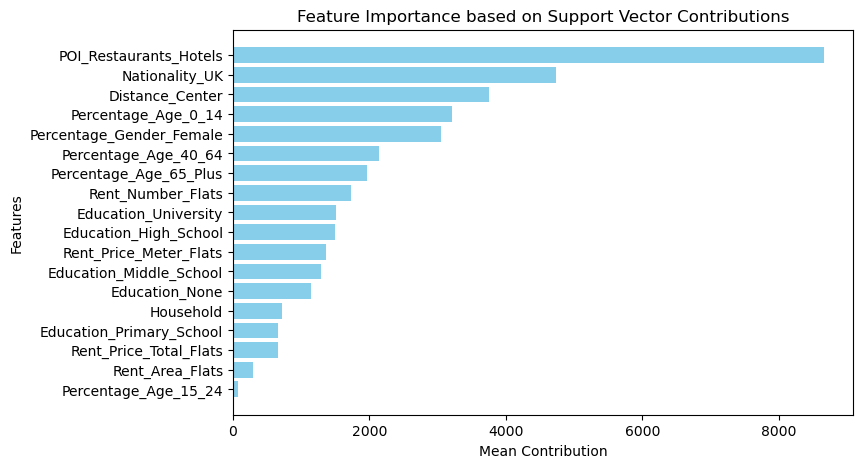

In [17]:
feature_names = list(X.columns)

svr_model = model_svr.named_steps["regressor"]

support_vectors = svr_model.support_vectors_
dual_coef = svr_model.dual_coef_

# Compute the contribution of each support vector to the decision function
# Multiply support vectors by their corresponding dual coefficients
support_vector_contributions = np.abs(dual_coef @ support_vectors)

mean_contributions = np.mean(support_vector_contributions, axis=0)

feature_contributions = {
    feature_names[i]: mean_contributions[i] for i in range(len(feature_names))
}

nationality_features = [
    name
    for name in feature_names
    if name.startswith("Nationality") or name == "Nicaragua"
]
poi_features = [name for name in feature_names if name.startswith("POI")]
max_nationality_feature = max(
    nationality_features, key=lambda name: feature_contributions[name], default=None
)
max_poi_feature = max(
    poi_features, key=lambda name: feature_contributions[name], default=None
)

features_to_keep = (
    [max_nationality_feature, max_poi_feature]
    if max_nationality_feature and max_poi_feature
    else []
)

features_to_keep.extend(
    [
        name
        for name in feature_names
        if not (
            name.startswith("Nationality")
            or name.startswith("POI")
            or name == "Nicaragua"
        )
    ]
)

filtered_contributions = [feature_contributions[name] for name in features_to_keep]

sorted_indices = np.argsort(filtered_contributions)[::-1]
sorted_contributions = np.array(filtered_contributions)[sorted_indices]
sorted_feature_names = np.array(features_to_keep)[sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(8, 5))
plt.barh(sorted_feature_names, sorted_contributions, color="skyblue")
plt.xlabel("Mean Contribution")
plt.ylabel("Features")
plt.title("Feature Importance based on Support Vector Contributions")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# 2nd Model: linear model variables 

A possibility is to use the best variables from the linear model: 

In [18]:
linear_coefs = pd.read_csv(DIR_MONTH / "01_linear/coefficients.csv", index_col=0)
best_model_linear = linear_coefs.drop(["Intercept"], axis=1).columns

X_chosen = sect[best_model_linear]

print(best_model_linear)

Index(['Distance_Center', 'POI_Restaurants_Hotels', 'Nationality_Italy',
       'Nationality_UK', 'Percentage_Age_65_Plus', 'Percentage_Age_0_14'],
      dtype='object')


In [19]:
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("scaler", StandardScaler())])

pipe_svr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", SVR(C=1024, epsilon=1, kernel='linear'))]
)

### Model evaluation

In [20]:
model_svr_red = pipe_svr.fit(X_chosen, y)

y_pred = model_svr_red.predict(X_chosen)
y_pred = pd.Series(
    y_pred, index=geo_info.index, name="SVR"
)  # relating the pred values with the geographical tags

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
n, p = len(y), X.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
evs = explained_variance_score(y, y_pred)
aic = len(y) * np.log(mse) + 2 * p

residuals = y - y_pred

svr_metrics = {
    "MSE": [mse],
    "RMSE": [rmse],
    "R^2": [r2],
    "Adj R^2": [adjusted_r2],
    "EVs": [evs],
    "AIC": [aic],
}
df_svr_metrics_red = pd.DataFrame(svr_metrics, index=["Linear SVR"])

df_metrics_red = pd.read_csv("metrics_red.csv", index_col=0)
df_metrics_red = pd.concat([df_metrics_red, df_svr_metrics_red])
df_metrics_red.to_csv("metrics_red.csv", index=True)
df_metrics_red

,MSE,RMSE,R^2,Adj R^2,EVs,AIC
Linear Regression,160.004466,12.649287,0.757999,0.753377,0.762458,5460.315447
GWR,92.873596,9.637095,0.859532,0.858738,0.862931,1481.899846
MESF-Queen,151.535571,12.309979,0.770808,0.748666,0.770808,5550.236174
MESF-KNN,149.073928,12.209583,0.774531,0.752749,0.774531,5532.744424
MESF-Gabriel,147.121775,12.129377,0.777484,0.755987,0.777484,5518.666371
SVR,37.509157,6.124472,0.943269,0.938421,0.944206,4039.056882
GWSVR,221.596309,14.886111,0.664844,0.636204,0.671020,5936.115593
SVR,37.509157,6.124472,0.943269,0.938421,0.944206,4039.056882


#### Spatial Autocorrelation handling

##### Moran's I on residuals 

In [21]:
from libpysal.weights import Queen
from esda.moran import Moran


def calculate_morans_i(residuals, geo_info):
    w = Queen.from_dataframe(geo_info)
    w.transform = "R"
    moran = Moran(residuals, w)
    return moran.I, moran.p_sim


moran = calculate_morans_i(residuals, geo_info)
print(f"Moran's I: {moran[0]}, p-value: {moran[1]}")

Moran's I: 0.12212578735279678, p-value: 0.001


##### Cross validation with training and test sets for different sections

In [22]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = cross_val_score(
    pipe_svr, X_chosen, y, cv=kf, scoring="neg_mean_squared_error"
)

mean_mse = -np.mean(mse_scores)

In [23]:
autocorr_metrics = {"Moran's I": [moran[0]], "Mean MSE": [mean_mse]}
df_autocorr_svr_metrics_red = pd.DataFrame(autocorr_metrics, index=["Linear SVR"])

df_autocorr_metrics_red = pd.read_csv("metrics_autocorr_red.csv", index_col=0)
df_autocorr_metrics_red = pd.concat(
    [df_autocorr_metrics_red, df_autocorr_svr_metrics_red]
)
df_autocorr_metrics_red.to_csv("metrics_autocorr_red.csv", index=True)
df_autocorr_metrics_red

,Moran's I,Mean MSE
Linear Regression,0.214738,178.444837
GWR,0.101605,120.867957
MESF-Queen,0.224924,252.064666
MESF-KNN,0.176038,236.256972
MESF-Gabriel,0.151428,255.266136
SVR,0.122126,295.315257
GWSVR,0.505956,NaN
SVR,0.122126,295.315257


In [24]:
df_predictions_svr = pd.DataFrame({"Linear SVR": np.array(y_pred)})
df_predictions_red = pd.read_csv("predictions_red.csv", index_col=0)
df_predictions_red = pd.concat([df_predictions_red, df_predictions_svr], axis=1)
df_predictions_red.to_csv("predictions_red.csv")
df_predictions_red

,y,Linear Regression,GWR,MESF-Q,MESF-K,MESF-G,SVR,GWSVR,GWSVR.1,SVR
0,76,80.116570,74.0,78.788502,77.417599,79.209439,75.000357,74.028969,43.954807,65.795454
1,61,64.307523,44.0,61.744177,61.695660,62.114164,60.000187,66.550022,29.893908,60.000167
2,50,37.518577,27.0,39.172746,37.617358,41.064195,49.000139,35.924829,30.300741,49.000371
3,82,76.720780,68.0,75.822136,76.570385,77.382745,81.000239,65.378482,48.643988,81.000372
4,108,95.588241,58.0,96.024349,97.085118,94.205170,107.000223,77.194040,55.831853,107.000056
...,...,...,...,...,...,...,...,...,...,...
1063,1,-2.148651,2.0,-6.023376,-1.865126,-5.117239,0.528833,0.818385,-1.553915,1.191800
1064,6,2.940087,4.0,3.446457,2.601677,2.442538,4.999644,6.051567,9.547738,6.814445
1065,7,-4.402845,4.0,-7.901989,-8.076774,-6.695285,8.000002,3.329263,6.076590,4.343745
1066,4,5.976093,4.0,2.970398,1.929307,3.699902,4.999759,6.705815,7.153998,5.000156


### Coefficients - support vectors

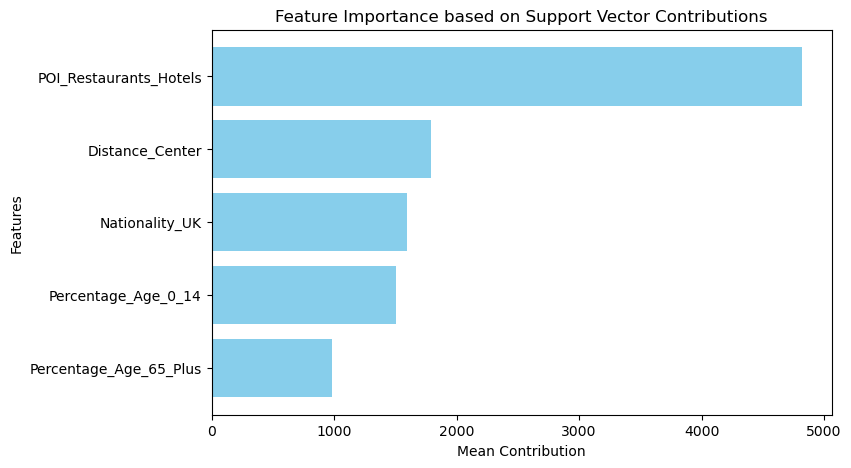

In [26]:
### Coefficients - support vectors
feature_names = list(X_chosen.columns)

svr_model_red = model_svr_red.named_steps["regressor"]

support_vectors_red = svr_model_red.support_vectors_
dual_coef_red = svr_model_red.dual_coef_

# Compute the contribution of each support vector to the decision function
# Multiply support vectors by their corresponding dual coefficients
support_vector_contributions_red = np.abs(dual_coef_red @ support_vectors_red)

mean_contributions = np.mean(support_vector_contributions_red, axis=0)

feature_contributions = {
    feature_names[i]: mean_contributions[i] for i in range(len(feature_names))
}

nationality_features = [
    name
    for name in feature_names
    if name.startswith("Nationality") or name == "Nicaragua"
]
poi_features = [name for name in feature_names if name.startswith("POI")]
max_nationality_feature = max(
    nationality_features, key=lambda name: feature_contributions[name], default=None
)
max_poi_feature = max(
    poi_features, key=lambda name: feature_contributions[name], default=None
)

features_to_keep = (
    [max_nationality_feature, max_poi_feature]
    if max_nationality_feature and max_poi_feature
    else []
)

features_to_keep.extend(
    [
        name
        for name in feature_names
        if not (
            name.startswith("Nationality")
            or name.startswith("POI")
            or name == "Nicaragua"
        )
    ]
)

filtered_contributions = [feature_contributions[name] for name in features_to_keep]

sorted_indices = np.argsort(filtered_contributions)[::-1]
sorted_contributions = np.array(filtered_contributions)[sorted_indices]
sorted_feature_names = np.array(features_to_keep)[sorted_indices]

# Plot the sorted feature importance
plt.figure(figsize=(8, 5))
plt.barh(sorted_feature_names, sorted_contributions, color="skyblue")
plt.xlabel("Mean Contribution")
plt.ylabel("Features")
plt.title("Feature Importance based on Support Vector Contributions")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()